In [3]:
!pip3 install -q --upgrade pip
!pip3 install -q pandas numpy matplotlib seaborn openpyxl climateserv requests netCDF4 xarray pyproj geopandas Fiona
!pip3 install -q GDAL==3.8.2

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import BallTree
import numpy as np

In [5]:
# Load your data into pandas DataFrames

path_to_df1 = '../../data/processed_data/igrac/wells_df.csv'
path_to_df2 = '../../data/processed_data/appears/nasadem/nasadem_data.csv'


# Load your data from the CSV files into pandas DataFrames
df1 = pd.read_csv(path_to_df1)
df2 = pd.read_csv(path_to_df2)

# Convert the dataframes to GeoDataFrames
gdf_wells = gpd.GeoDataFrame(
    df1, 
    geometry=[Point(xy) for xy in zip(df1.Longitude, df1.Latitude)]
)

gdf_topo = gpd.GeoDataFrame(
    df2, 
    geometry=[Point(xy) for xy in zip(df2.lon, df2.lat)]
)

# Create a BallTree with the topology data
tree = BallTree(np.array(list(zip(gdf_topo.geometry.y, gdf_topo.geometry.x))), metric='haversine')

# Find the closest point in the topology data for each well
indices = tree.query(np.array(list(zip(gdf_wells.geometry.y, gdf_wells.geometry.x))), k=1, return_distance=False)

# Map the NASADEM_HGT value from the closest topology point to the wells
gdf_wells['NASADEM_HGT'] = gdf_topo.iloc[indices.flatten()]['NASADEM_HGT'].values

# Convert the GeoDataFrame back to a regular DataFrame if necessary
df1['NASADEM_HGT'] = gdf_wells['NASADEM_HGT']

In [18]:
# Save the DataFrame to a CSV file
path_to_save_csv = '../../data/processed_data/combination/combined_igrac_wells_nad_topograhpy_nasadem.csv'
df1.to_csv(path_to_save_csv, index=False)

In [17]:
gdf_wells.head()

,ID,Name,Status,Latitude,Longitude,Ground surface elevation\n,geometry,NASADEM_HGT
0,0000058001,Yoro Beri Kunda,Active,13.498482,-14.757303,17.40,POINT (-14.75730 13.49848),18.0
1,0000035001,Pakaliba,Active,13.517245,-15.242125,13.34,POINT (-15.24213 13.51725),17.0
2,0000024001,Somita,Active,13.208963,-16.298932,27.31,POINT (-16.29893 13.20896),33.0
3,0000023001,Taneneh,Active,13.233057,-16.504728,14.32,POINT (-16.50473 13.23306),18.0
4,0000020007,Mandinari OB3,Active,13.362761,-16.637219,30.47,POINT (-16.63722 13.36276),33.0


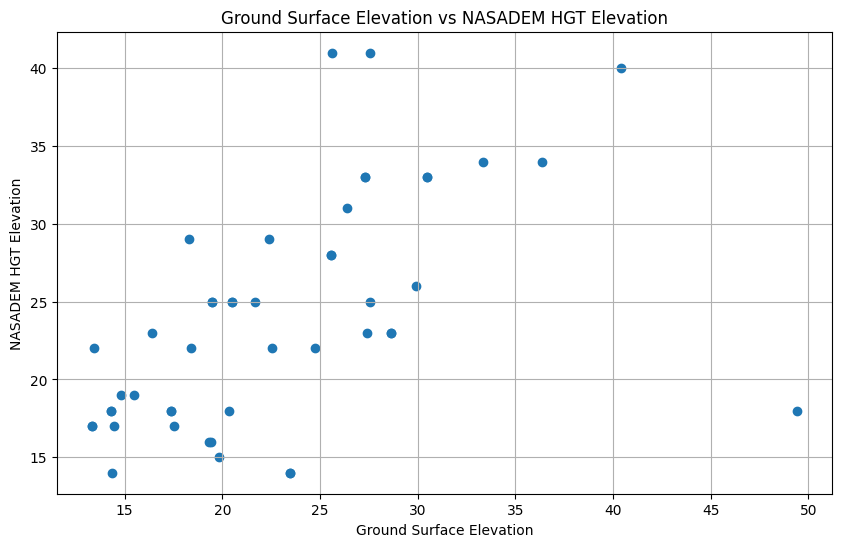

In [10]:
import matplotlib.pyplot as plt

# Assuming gdf_wells is your GeoDataFrame
plt.figure(figsize=(10, 6))
plt.scatter(gdf_wells['Ground surface elevation\n'], gdf_wells['NASADEM_HGT'])
plt.xlabel('Ground Surface Elevation')
plt.ylabel('NASADEM HGT Elevation')
plt.title('Ground Surface Elevation vs NASADEM HGT Elevation')
plt.grid(True)
plt.show()


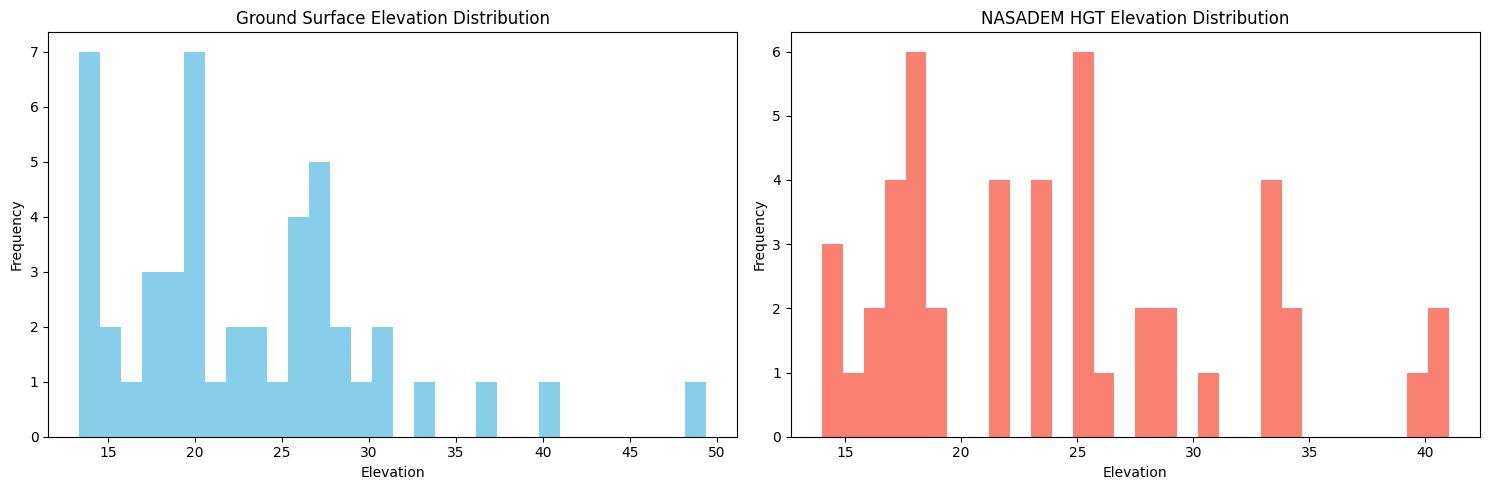

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

gdf_wells['Ground surface elevation\n'].plot(kind='hist', ax=axs[0], bins=30, color='skyblue')
axs[0].set_title('Ground Surface Elevation Distribution')
axs[0].set_xlabel('Elevation')

gdf_wells['NASADEM_HGT'].plot(kind='hist', ax=axs[1], bins=30, color='salmon')
axs[1].set_title('NASADEM HGT Elevation Distribution')
axs[1].set_xlabel('Elevation')

plt.tight_layout()
plt.show()


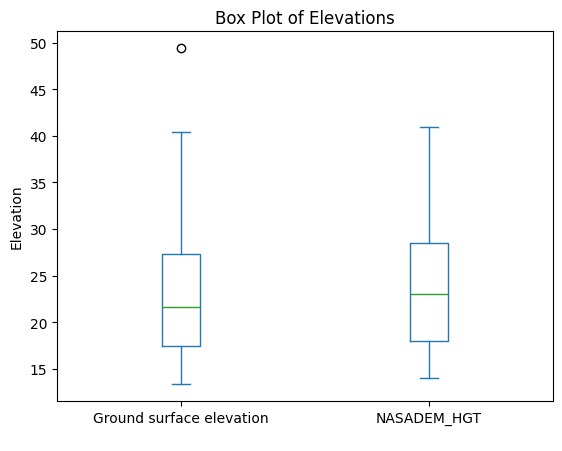

In [16]:
gdf_wells[['Ground surface elevation\n', 'NASADEM_HGT']].plot(kind='box')
plt.title('Box Plot of Elevations')
plt.ylabel('Elevation')
plt.show()
